In [22]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import numpy as np
import matplotlib.pyplot as plt
import random

import os
import h5py
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D

In [2]:
def generate_spiral_dataset(N, K):
    X = np.zeros((N*K, 2)) # data matrix (each row = single example)
    y = np.zeros(N*K, dtype='uint8') # class labels

    for j in range(K):
        ix = range(N*j, N*(j+1))
        r = np.linspace(0.0, 1, N) # rayon
        t = np.linspace(j*4, (j+1)*4, N) + np.random.randn(N)*0.2 # theta
        X[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
        y[ix] = j

    return X, y

In [3]:
N = 100 # nombre de points par classe
K = 3 # nombre de classes
X, Y = generate_spiral_dataset(N, K)

X = X
Y_classes = Y

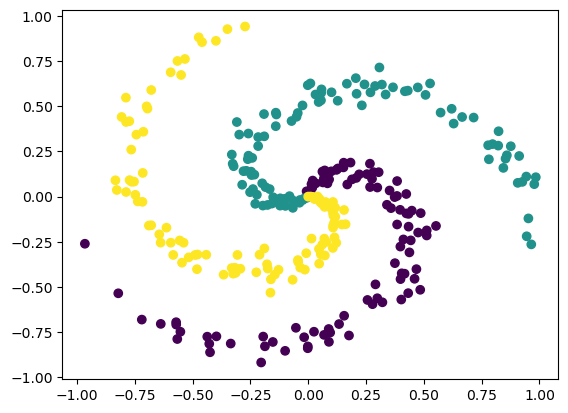

In [4]:
plt.scatter(X[:, 0], X[:, 1], c=Y)

In [5]:
X = torch.tensor(X, dtype=torch.float32)
Y = torch.tensor(Y)

In [6]:
device = 'cpu' #torch.device("cuda")

In [143]:
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(2, 100)
        self.fc2 = nn.Linear(100, 30)
        self.fc3 = nn.Linear(30, 3)

    def forward(self, x):
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        return x
    
    def predict(self, x):
        output = self.forward(x)
        return torch.argmax(output, axis=1)

model = MLP()
model.to(device)

optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4)

In [144]:
for epoch in range(1000):
    logits = model(X)
    optimizer.zero_grad()
    loss = F.cross_entropy(logits, Y)
    loss.backward()
    optimizer.step()
print(loss.item())

0.030633075162768364


In [145]:
torch.save(model.state_dict(), "last_model")

In [141]:
checkpoint = torch.load("last_model")
model.load_state_dict(checkpoint)

<All keys matched successfully>

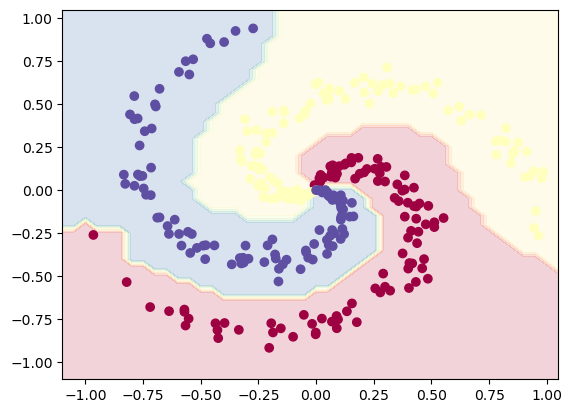

In [142]:
xx, yy = np.meshgrid(np.arange(-1.1, 1.1, 0.05), np.arange(-1.1, 1.1, 0.05))
X_disp = np.c_[xx.ravel(), yy.ravel()].T

h = model.predict(torch.from_numpy(X_disp.T.astype(np.float32)))
h = h.reshape(xx.shape)

plt.contourf(xx, yy, h, cmap=plt.cm.Spectral, alpha=0.2)
plt.scatter(X[:, 0], X[:, 1], c=Y_classes, cmap=plt.cm.Spectral)

In [93]:
def eval_loss(model):
    correct = 0

    logits = model(X)

    loss = F.cross_entropy(logits, Y)

    pred = F.log_softmax(logits, dim=1).argmax(dim=1, keepdim=True)
    correct = pred.eq(Y.view_as(pred)).sum().item()
    
    return loss.item(), correct/len(X)

In [94]:
def create_random_directions(model):
    x_direction = create_random_direction(model)
    y_direction = create_random_direction(model)

    return [x_direction, y_direction]

def create_random_direction(model):
    weights = get_weights(model)
    direction = get_random_weights(weights)
    normalize_directions_for_weights(direction, weights)

    return direction

def get_weights(model):
    return [p.data for p in model.parameters()]

def get_random_weights(weights):
    return [torch.randn(w.size()).to(device) for w in weights]

def normalize_direction(direction, weights):
    for d, w in zip(direction, weights): 
        d.mul_(w.norm() / (d.norm() + 1e-10)) 

def normalize_directions_for_weights(direction, weights):
    assert (len(direction) == len(weights))
    for d, w in zip(direction, weights):
        if d.dim() <= 1:
            d.fill_(0) 
        normalize_direction(d, w)

In [124]:
def calulate_loss_landscape(model, directions, save_path):
    """
    directions : filter-wise normalized directions(d = (d / d.norm) * w.norm, d is random vector from gausian distribution)
    To make d have the same norm as w.
    """
    surface_path = setup_surface_file(save_path)
    init_weights = [p.data for p in model.parameters()] # pretrained weights

    with h5py.File(surface_path, 'r+') as f:

        xcoordinates = f['xcoordinates'][:]
        ycoordinates = f['ycoordinates'][:]
        losses = f["train_loss"][:]
        accuracies = f["train_acc"][:]

        inds, coords = get_indices(losses, xcoordinates, ycoordinates)

        for count, ind in enumerate(inds):
            print("ind...%s" % ind)
            coord = coords[count]
            overwrite_weights(model, init_weights, directions, coord)

            loss, acc = eval_loss(model)
            print(loss, acc)

            losses.ravel()[ind] = loss 
            accuracies.ravel()[ind] = acc

            print('Evaluating %d/%d  (%.1f%%)  coord=%s' % (
                ind, len(inds), 100.0 * count / len(inds), str(coord)))

            f["train_loss"][:] = losses
            f["train_acc"][:] = accuracies
            f.flush()

            #if ind % 300 == 0:
            #    break

    return surface_path

def setup_surface_file(save_path):
    surface_path = f"{save_path}/3d_surface_file.h5"


    with h5py.File(surface_path, 'w') as f:
        print("Create new 3d_sureface_file.h5")

        xcoordinates = np.linspace(-1, 1, 51)
        f['xcoordinates'] = xcoordinates

        ycoordinates = np.linspace(-1, 1, 51)
        f['ycoordinates'] = ycoordinates

        shape = (len(xcoordinates), len(ycoordinates))
        losses = -np.ones(shape=shape)
        accuracies = np.ones(shape=shape)

        f["train_loss"] = losses
        f["train_acc"] = accuracies

        return surface_path


def get_indices(vals, xcoordinates, ycoordinates):
    inds = np.array(range(vals.size)) 
    inds = inds[vals.ravel() <= 0]

    xcoord_mesh, ycoord_mesh = np.meshgrid(xcoordinates, ycoordinates)
    s1 = xcoord_mesh.ravel()[inds]
    s2 = ycoord_mesh.ravel()[inds]

    return inds, np.c_[s1, s2] 


def overwrite_weights(model, init_weights, directions, step):
    dx = directions[0] # Direction vector present in the scale of weights
    dy = directions[1]
    changes = [d0 * step[0] + d1 * step[1] for (d0, d1) in zip(dx, dy)] #  αδ + βη
    
    for (p, w, d) in zip(model.parameters(), init_weights, changes):
        p.data = w + d # θ^* + αδ + βη

In [96]:
def visualize(save_path, surface_path):
    result_file_path = os.path.join(save_path, '2D_images/')
    if not os.path.isdir(result_file_path):
        os.makedirs(result_file_path)
    surf_name = "train_loss"

    with h5py.File(surface_path,'r') as f:

        Z_LIMIT = 10

        x = np.array(f['xcoordinates'][:])
        y = np.array(f['ycoordinates'][:])

        X, Y = np.meshgrid(x, y)
        
        if surf_name in f.keys():
            Z = np.array(f[surf_name][:])
        elif surf_name == 'train_acc' or surf_name == 'test_acc' :
            Z = 100 - np.array(f[surf_name][:])
        else:
            print ('%s is not found in %s' % (surf_name, surface_path))
        
        Z = np.array(f[surf_name][:])
        #Z[Z > Z_LIMIT] = Z_LIMIT
        #Z = np.log(Z)  # logscale

        # Save 2D contours image
        fig = plt.figure()
        CS = plt.contour(X, Y, Z, cmap = 'summer', levels=np.arange(0.1, 10, 0.5))
        plt.clabel(CS, inline=1, fontsize=8)
        fig.savefig(result_file_path + surf_name + '_2dcontour' + '.pdf', dpi=300,
                    bbox_inches='tight', format='pdf')

        fig = plt.figure()
        CS = plt.contourf(X, Y, Z, levels=np.arange(0.1, 10, 0.5))
        plt.clabel(CS, inline=1, fontsize=8)
        fig.savefig(result_file_path + surf_name + '_2dcontourf' + '.pdf', dpi=300,
                    bbox_inches='tight', format='pdf')

        # Save 2D heatmaps image
        plt.figure()
        sns_plot = sns.heatmap(Z, cmap='viridis', cbar=True, vmin=0.1, vmax=10,
                               xticklabels=False, yticklabels=False)
        sns_plot.invert_yaxis()
        sns_plot.get_figure().savefig(result_file_path + surf_name + '_2dheat.pdf',
                                      dpi=300, bbox_inches='tight', format='pdf')

        # Save 3D surface image
        plt.figure()
        ax = Axes3D(fig)
        ax.plot_surface(X, Y, Z, linewidth=0, antialiased=True)
        fig.savefig(result_file_path + surf_name + '_3dsurface.pdf', dpi=300,
                    bbox_inches='tight', format='pdf')

In [97]:
rand_directions = create_random_directions(model) # liste de 2 x 6 tensors (j'ai 6 tensors de params. dans mon réseau)
surface_path = calulate_loss_landscape(model, rand_directions, "res/")

Create new 3d_sureface_file.h5
ind...0
6.918997287750244 0.43666666666666665
Evaluating 0/2601  (0.0%)  coord=[-1. -1.]
ind...1
6.571711540222168 0.43666666666666665
Evaluating 1/2601  (0.0%)  coord=[-0.96 -1.  ]
ind...2
6.237304210662842 0.44333333333333336
Evaluating 2/2601  (0.1%)  coord=[-0.92 -1.  ]
ind...3
5.916633129119873 0.44666666666666666
Evaluating 3/2601  (0.1%)  coord=[-0.88 -1.  ]
ind...4
5.607786655426025 0.44333333333333336
Evaluating 4/2601  (0.2%)  coord=[-0.84 -1.  ]
ind...5
5.310161113739014 0.44333333333333336
Evaluating 5/2601  (0.2%)  coord=[-0.8 -1. ]
ind...6
5.02152156829834 0.44333333333333336
Evaluating 6/2601  (0.2%)  coord=[-0.76 -1.  ]
ind...7
4.7408342361450195 0.44666666666666666
Evaluating 7/2601  (0.3%)  coord=[-0.72 -1.  ]
ind...8
4.47058629989624 0.44666666666666666
Evaluating 8/2601  (0.3%)  coord=[-0.68 -1.  ]
ind...9
4.214792251586914 0.44666666666666666
Evaluating 9/2601  (0.3%)  coord=[-0.64 -1.  ]
ind...10
3.9723949432373047 0.4466666666666666

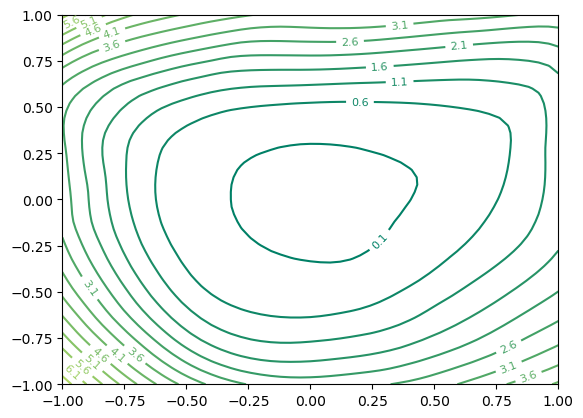

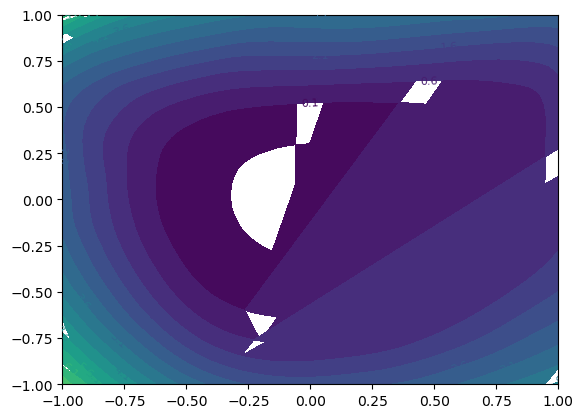

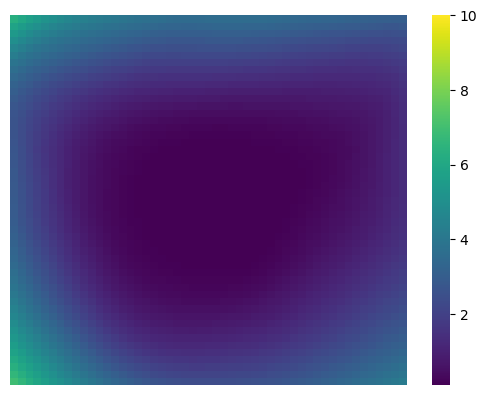

<Figure size 640x480 with 0 Axes>

In [98]:
visualize("res/", surface_path)

In [99]:
with h5py.File('res/3d_surface_file.h5', 'r') as f:
    x = f['xcoordinates'][:]
    y = f['ycoordinates'][:]
    losses = f['train_loss'][:]

In [52]:
x, y

(array([-1.  , -0.96, -0.92, -0.88, -0.84, -0.8 , -0.76, -0.72, -0.68,
        -0.64, -0.6 , -0.56, -0.52, -0.48, -0.44, -0.4 , -0.36, -0.32,
        -0.28, -0.24, -0.2 , -0.16, -0.12, -0.08, -0.04,  0.  ,  0.04,
         0.08,  0.12,  0.16,  0.2 ,  0.24,  0.28,  0.32,  0.36,  0.4 ,
         0.44,  0.48,  0.52,  0.56,  0.6 ,  0.64,  0.68,  0.72,  0.76,
         0.8 ,  0.84,  0.88,  0.92,  0.96,  1.  ]),
 array([-1.  , -0.96, -0.92, -0.88, -0.84, -0.8 , -0.76, -0.72, -0.68,
        -0.64, -0.6 , -0.56, -0.52, -0.48, -0.44, -0.4 , -0.36, -0.32,
        -0.28, -0.24, -0.2 , -0.16, -0.12, -0.08, -0.04,  0.  ,  0.04,
         0.08,  0.12,  0.16,  0.2 ,  0.24,  0.28,  0.32,  0.36,  0.4 ,
         0.44,  0.48,  0.52,  0.56,  0.6 ,  0.64,  0.68,  0.72,  0.76,
         0.8 ,  0.84,  0.88,  0.92,  0.96,  1.  ]))

In [53]:
losses

array([[10.63188362, 10.34539795, 10.06610584, ..., 11.19395447,
        11.60762691, 12.04277706],
       [10.08707333,  9.80355835,  9.52545357, ..., 10.64255333,
        11.05531216, 11.48591995],
       [ 9.57199478,  9.28672409,  9.01034641, ..., 10.11272049,
        10.52162266, 10.95334625],
       ...,
       [11.28885841, 10.8144846 , 10.36579704, ...,  3.99648142,
         4.03026342,  4.07032204],
       [11.75245571, 11.26743412, 10.80706024, ...,  4.33290672,
         4.35953426,  4.39313698],
       [12.22566795, 11.73104286, 11.26335812, ...,  4.69214392,
         4.72555542,  4.75949287]])

In [54]:
from scipy.interpolate import RectBivariateSpline
loss_func = RectBivariateSpline(x, y, losses)

In [61]:
loss_func(-0.96, -0.96)[0, 0]

9.80355834960938

In [131]:
model.state_dict()

OrderedDict([('fc1.weight',
              tensor([[ 6.9409e-01,  6.9829e-02],
                      [-1.4672e+00, -1.4215e+00],
                      [ 8.5838e-02,  1.0540e+00],
                      [ 6.6194e-01, -6.4339e-01],
                      [-3.7343e-01,  1.1735e+00],
                      [ 8.2358e-01,  3.0360e-01],
                      [-1.6182e-01, -1.8645e-01],
                      [ 5.9325e-01,  2.1640e+00],
                      [ 2.1364e-02, -8.0871e-01],
                      [ 1.9775e-01,  1.8160e-01],
                      [-8.9622e-02,  5.2400e-01],
                      [-1.6551e+00, -1.5063e+00],
                      [-1.5455e+00,  3.5345e-01],
                      [-2.0573e+00,  2.6154e+00],
                      [ 2.5761e-01,  8.8942e-01],
                      [ 7.5557e-01,  6.1108e-02],
                      [ 1.5281e-01,  4.1165e-01],
                      [ 5.7882e-01,  1.5150e+00],
                      [-6.5409e-01,  7.9879e-01],
                      

In [ ]:
model.load_state_dict()

In [157]:
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()

        self.fc1 = nn.Linear(2, 100)
        self.fc2 = nn.Linear(100, 100)
        self.fc3 = nn.Linear(100, 100)
        self.fc4 = nn.Linear(100, 100)
        self.fc5 = nn.Linear(100, 100)
        self.fc6 = nn.Linear(100, 100)
        self.fc7 = nn.Linear(100, 100)
        self.fc8 = nn.Linear(100, 100)
        self.fc9 = nn.Linear(100, 100)
        self.fc10 = nn.Linear(100, 3)

    def forward(self, x):
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        x = F.relu(x)
        x = self.fc4(x)
        x = F.relu(x)
        x = self.fc5(x)
        x = F.relu(x)
        x = self.fc6(x)
        x = F.relu(x)
        x = self.fc7(x)
        x = F.relu(x)
        x = self.fc8(x)
        x = F.relu(x)
        x = self.fc9(x)
        x = F.relu(x)
        x = self.fc10(x)
        
        return x
    
    def predict(self, x):
        output = self.forward(x)
        return torch.argmax(output, axis=1)

model = MLP()
model.to(device)

#optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)
optimizer = optim.Adam(model.parameters(), lr=0.01)

In [158]:
for epoch in range(1000):
    logits = model(X)
    optimizer.zero_grad()
    loss = F.cross_entropy(logits, Y)
    loss.backward()
    optimizer.step()
print(loss.item())

#interessant : SGD reste bloqué dans un local min, Adam cv.

0.010986130684614182
